<a href="https://colab.research.google.com/github/AvichalTrivedi7/Generative-AI-Intel-Unnati/blob/main/CNN_CIFAR_10_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Convolutional Neural Network (CNN)**
It is an advanced version of artificial neural networks (ANNs), primarily designed to extract features from grid-like matrix datasets. This is particularly useful for visual datasets such as images or videos, where data patterns play a crucial role. CNNs are widely used in computer vision applications due to their effectiveness in processing visual data.

CNNs consist of multiple layers like the input layer, Convolutional layer, pooling layer, and fully connected layers. Let's learn more about CNNs in detail.

![image.png](attachment:ecf02385-82c2-442f-9aac-b268dae90fdb.png)

### **How Convolutional Layers Works**

Convolution Neural Networks are neural networks that share their parameters.

The image that we have is represented as a cuboid having its length, width (dimension of the image), and height (i.e the channel as images generally have red, green, and blue channels).


![image.png](attachment:c13a6104-766a-4018-8feb-d799ed7e41ee.png)


When we take a small patch of this image and run a small neural network, called a filter or kernel, on it, with say, K outputs, and represent them vertically.

Now we are sliding that neural network across the whole image; as a result, we will get another image with different widths, heights, and depths. Instead of just R, G, and B channels, now we have more channels but a lesser width and height. This operation is called **Convolution**. If the patch size is the same as that of the image it will be a regular neural network. Because of this small patch, we have fewer weights.

![image.png](attachment:2f4bc9b0-d156-49c2-89e0-7d3ca7432990.png)


**Prerequisites**: !pip install openvino-dev
pip install onnx

**Import Libraries**

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
!pip install openvino
import openvino as ov
# from openvino.tools import mo # This line causes the ImportError and can be removed.
from openvino.runtime import Core, Tensor

**Load and Preprocess CIFAR-10 Dataset**

In [35]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### **CNN Architecture** [ Layers Used to Build ConvNets ]


A complete Convolution Neural Networks architecture is also known as covnets. A covnets is a sequence of layers, and every layer transforms one volume to another through a differentiable function.

Let’s take an example by running a covnets on of image of dimension 32 x 32 x 3.

-  **Input Layers:** It’s the layer in which we give input to our model. In CNN, Generally, the input will be an image or a sequence of images. This layer holds the raw input of the image with width 32, height 32, and depth 3.

-  **Convolutional Layers:** This is the layer that is used to extract the feature from the input dataset. It applies a set of learnable filters known as the kernels to the input images. The filters/kernels are smaller matrices, usually 2x2, 3x3, or 5x5 in shape. It slides over the input image data and computes the dot product between the kernel weight and the corresponding input image patch. The output of this layer is referred to as feature maps. Suppose we use a total of 12 filters for this layer, we’ll get an output volume of dimension 32 x 32 x 12.

-  **Activation Layer:** By adding an activation function to the output of the preceding layer, activation layers add nonlinearity to the network. It will apply an element-wise activation function to the output of the convolution layer. Some common activation functions are RELU: max(0, x),  Tanh, Leaky RELU, etc. The volume remains unchanged, hence output volume will have dimensions 32 x 32 x 12.


-  **Pooling layer:** This layer is periodically inserted in the covnets and its main function is to reduce the size of volume which makes the computation fast reduces memory and also prevents overfitting. Two common types of pooling layers are max pooling and average pooling. If we use a max pool with 2 x 2 filters and stride 2, the resultant volume will be of dimension 16x16x12.


![image.png](attachment:d9d5d646-17b0-41a0-951f-fef9ff507bb9.png)


-  **Flattening:** The resulting feature maps are flattened into a one-dimensional vector after the convolution and pooling layers so they can be passed into a completely linked layer for categorization or regression.
-   **Fully Connected Layers:** It takes the input from the previous layer and computes the final classification or regression task.
-   **Output Layer:** The output from the fully connected layers is then fed into a logistic function for classification tasks like sigmoid or softmax which converts the output of each class into the probability score of each class.

![image.png](attachment:ce6d84db-99c5-4176-b99e-bb6ee20495d4.png)


### **Step:**
-  import the necessary libraries
-  set the parameter
-  define the kernel
-  Load the image and plot it.
-  Reformat the image
-  Apply convolution layer operation and plot the output image.
-  Apply activation layer operation and plot the output image.
-  Apply pooling layer operation and plot the output image.

In [36]:
# Define a simple CNN with fewer layers and filters for faster training
class FastCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer: 3 input channels, 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Max pooling layer: 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: 16 input channels, 32 output channels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Fully connected layer: 32 feature maps (8x8) flattened to 128 neurons
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        # Output layer: 128 -> 10 classes
        self.fc2 = nn.Linear(128, 10)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(torch.relu(self.conv1(x)))
        # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 32 * 8 * 8)
        # Apply first fully connected layer and ReLU
        x = torch.relu(self.fc1(x))
        # Apply dropout
        x = self.dropout(x)
        # Apply output layer (logits)
        x = self.fc2(x)
        return x

# Instantiate the model
model = FastCNN()


**Train the CNN**

**Defining Loss Function and Optimizer**

**CrossEntropyLoss()** is used as the loss function for handling classification tasks by comparing predicted outputs with true labels. optim.SGD is chosen as the optimizer to update model weights using Stochastic Gradient Descent (SGD) with a learning rate of 0.001 and momentum of 0.9.

In [37]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Number of epochs (reduced for faster training)
epochs = 2

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")


Epoch 1, Loss: 1.561
Epoch 2, Loss: 1.272


**Evaluate the Model**

In [38]:
# Evaluate model accuracy on test data
correct = 0
total = 0
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 61.97%


**Convert PyTorch Model to OpenVINO IR**

In [39]:
pip install onnx

In [40]:
# Export PyTorch model to ONNX

!pip install onnxscript
dummy_input = torch.randn(1, 3, 32, 32).to(device)
torch.onnx.export(model, dummy_input, "cnn_cifar10.onnx", input_names=["input"], output_names=["output"], opset_version=11)

# Convert ONNX to OpenVINO IR
ov_model = ov.convert_model("cnn_cifar10.onnx")
ov.save_model(ov_model, "cnn_cifar10.xml")


W1216 04:26:58.614000 578 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `FastCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `FastCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


W1216 04:26:59.590000 578 torch/export/pt2_archive/_package.py:943] Unable to load package. f must be a buffer or a file ending in .pt2. Instead got {/content/cnn_cifar10.onnx}
W1216 04:26:59.667000 578 torch/export/__init__.py:451] Ran into the following error when deserializing: PytorchStreamReader failed reading zip archive: failed finding central directory
W1216 04:26:59.590000 578 torch/export/pt2_archive/_package.py:943] Unable to load package. f must be a buffer or a file ending in .pt2. Instead got {/content/cnn_cifar10.onnx}


**Run Inference with OpenVINO**

In [41]:
# Load OpenVINO model
core = Core()
compiled_model = core.compile_model("cnn_cifar10.xml", "CPU")

# Prepare input data
test_image, _ = next(iter(testloader))
test_image = test_image[0].unsqueeze(0).numpy()

# Run inference
start_time = time.time()
result = compiled_model(test_image)[0]
end_time = time.time()

ov_inference_time = end_time - start_time
print(f"OpenVINO Inference Time: {ov_inference_time:.4f} seconds")


OpenVINO Inference Time: 0.0029 seconds


**Compare Inference Speed and Accuracy**

In [42]:
# PyTorch inference time
model.to("cpu")
model.eval()
start_time = time.time()
with torch.no_grad():
    pytorch_output = model(torch.from_numpy(test_image))
end_time = time.time()
pytorch_inference_time = end_time - start_time

print(f"PyTorch Inference Time: {pytorch_inference_time:.4f} seconds")
print(f"OpenVINO Inference Time: {ov_inference_time:.4f} seconds")

# Compare accuracy (should be similar)
pytorch_pred = torch.argmax(pytorch_output, dim=1).item()
ov_pred = np.argmax(result)
print(f"PyTorch Prediction: {pytorch_pred}, OpenVINO Prediction: {ov_pred}")


PyTorch Inference Time: 0.0057 seconds
OpenVINO Inference Time: 0.0029 seconds
PyTorch Prediction: 3, OpenVINO Prediction: 3


**Visualize Results**

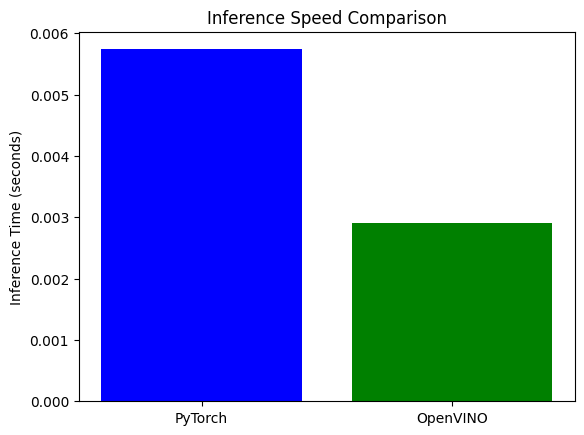

In [43]:
# Plot inference time comparison
labels = ['PyTorch', 'OpenVINO']
times = [pytorch_inference_time, ov_inference_time]
plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Speed Comparison')
plt.show()


True label: cat
Predicted label: cat


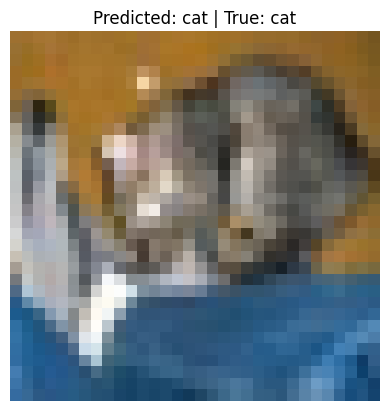

In [44]:
# Get one test image and label
test_image, true_label = next(iter(testloader))
input_image = test_image[0].unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run PyTorch model prediction
model.eval()
with torch.no_grad():
    output = model(input_image)
    predicted_label = torch.argmax(output, dim=1).item()

# Map prediction to class name
predicted_class = classes[predicted_label]
true_class = classes[true_label[0]]

print(f"True label: {true_class}")
print(f"Predicted label: {predicted_class}")

# Optional: visualize the test image
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize and convert to numpy for display
img = test_image[0].numpy()
img = np.transpose(img, (1, 2, 0))  # C x H x W to H x W x C
img = img * 0.5 + 0.5  # unnormalize
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} | True: {true_class}")
plt.axis('off')
plt.show()
